In [2]:
# Install required libraries
!pip install yfinance timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 32.2 MB/s eta

In [3]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [25]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [26]:
import timesfm


context_len=64
input_patch_len=32
horizon_len=1
batch_size=1


model = timesfm.TimesFm(
    context_len=context_len,
    horizon_len=horizon_len,
    input_patch_len=input_patch_len,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 4.50 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.40 seconds.
Jitting decoding.
Jitted decoding in 17.48 seconds.


Processing stock: فولاد


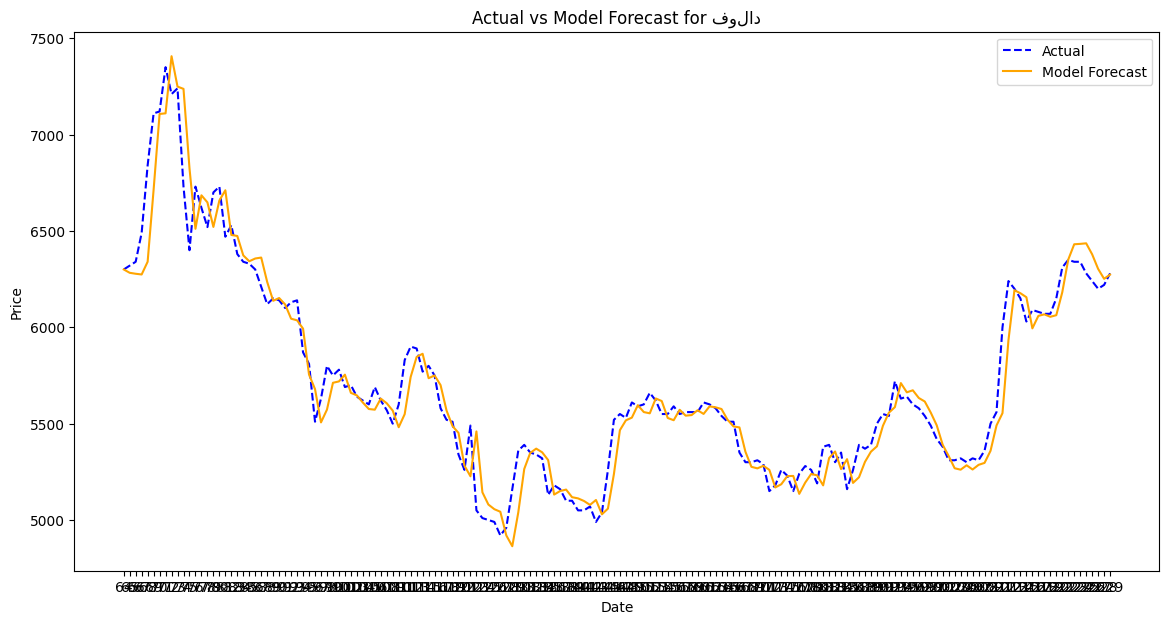

Processing stock: فملی


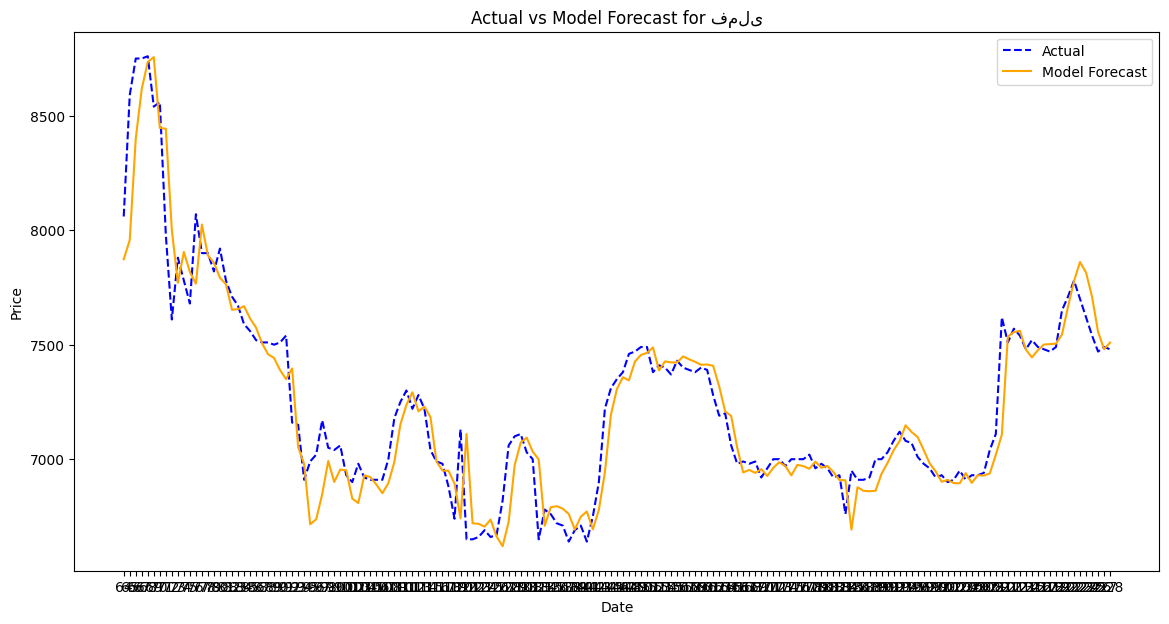

Processing stock: رمپنا


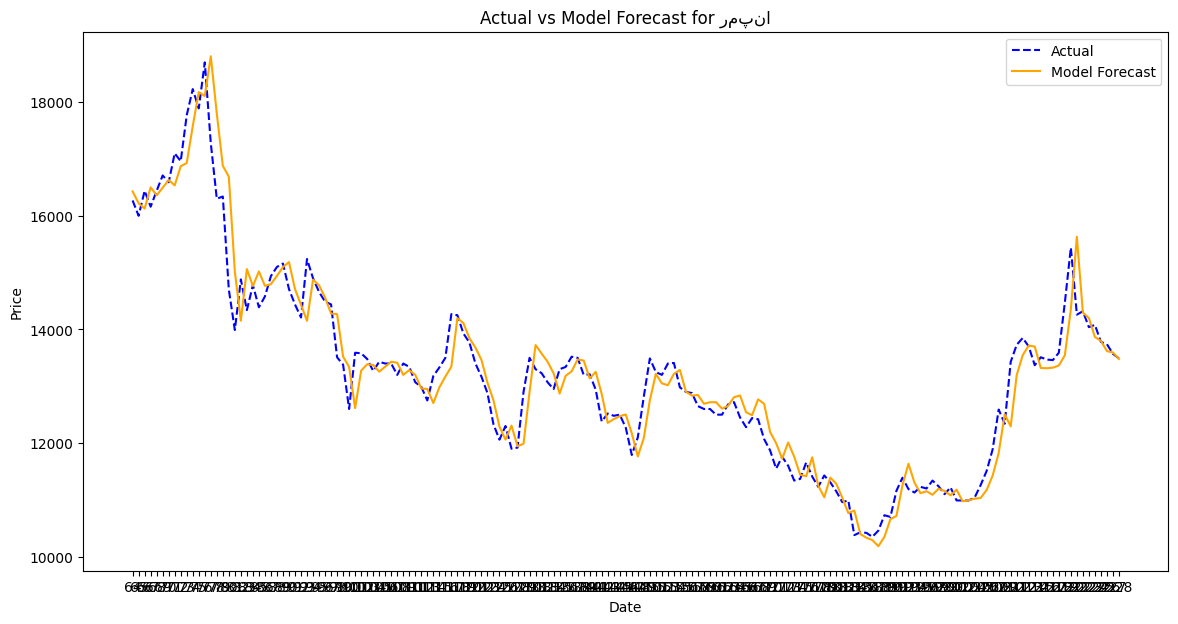

Processing stock: فارس


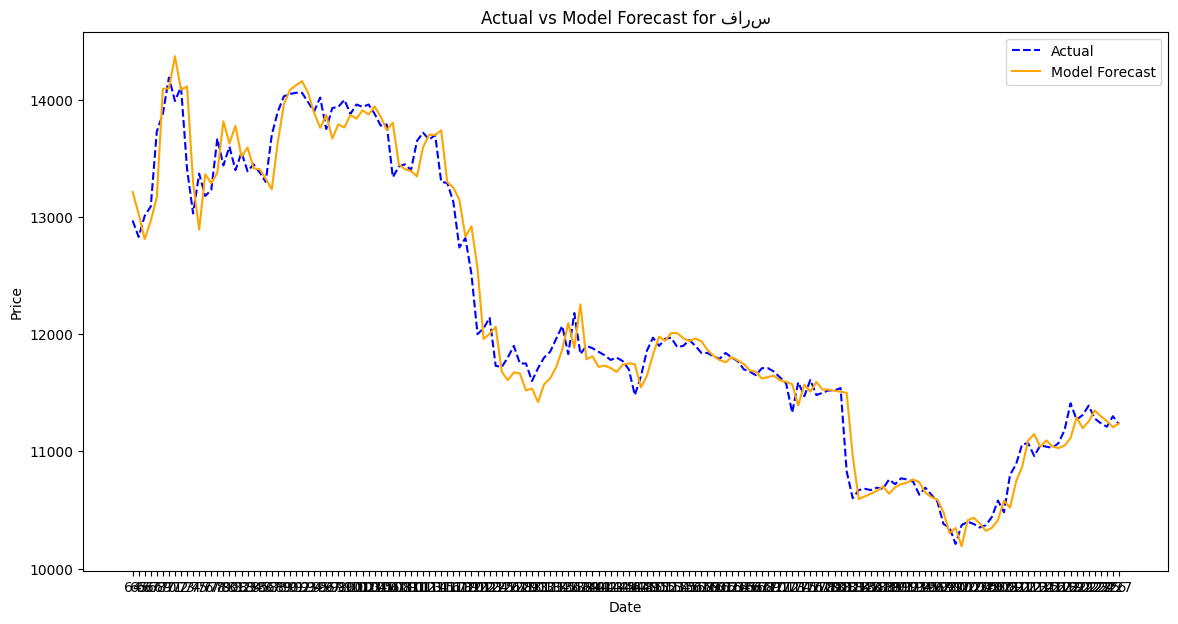

Processing stock: وبملت


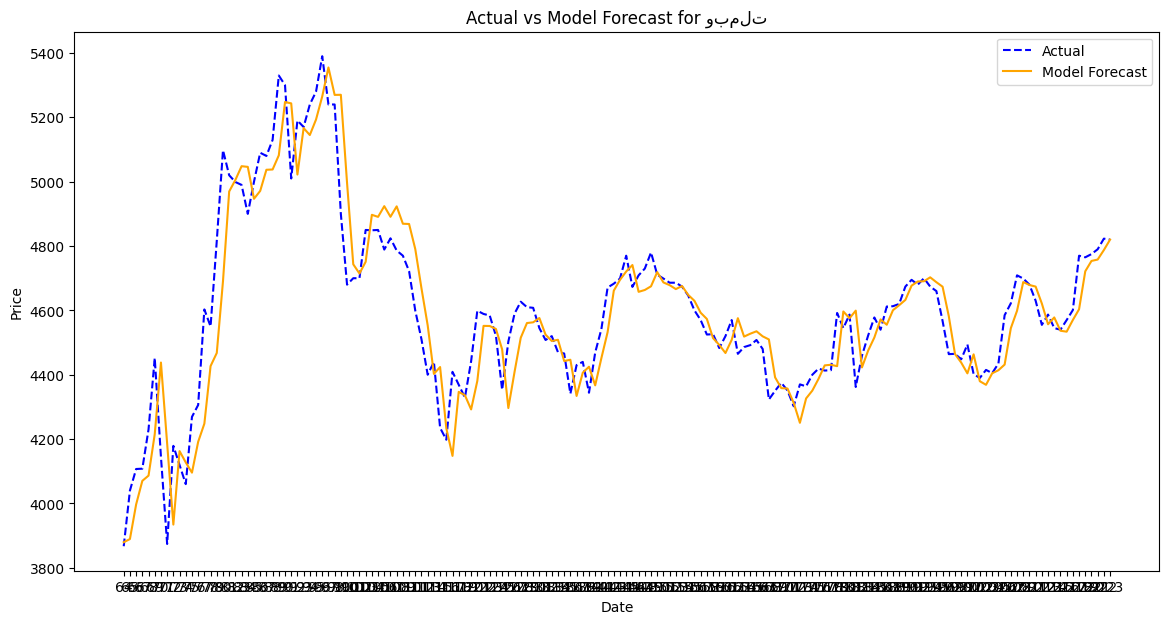

Processing stock: شپنا


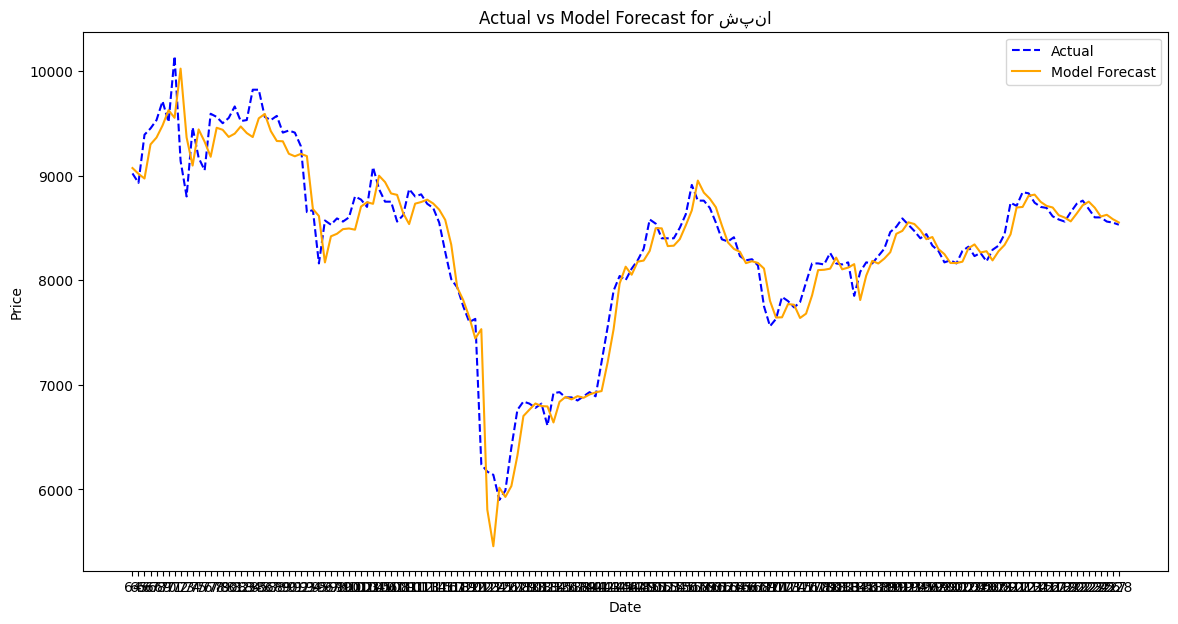

Processing stock: خساپا


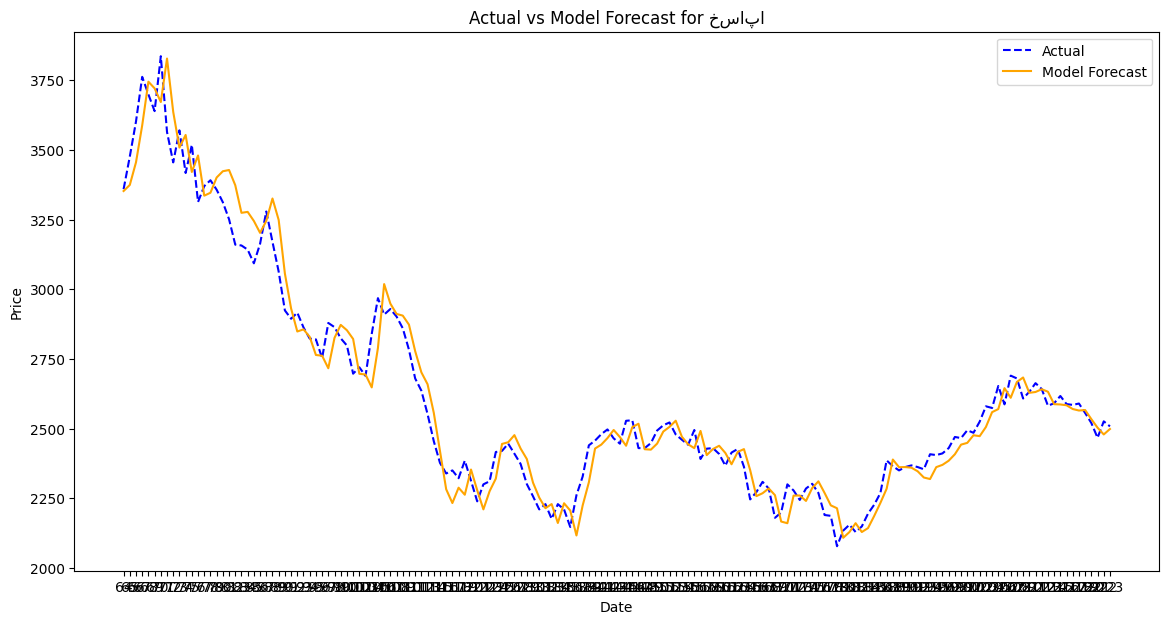

Processing stock: خودرو


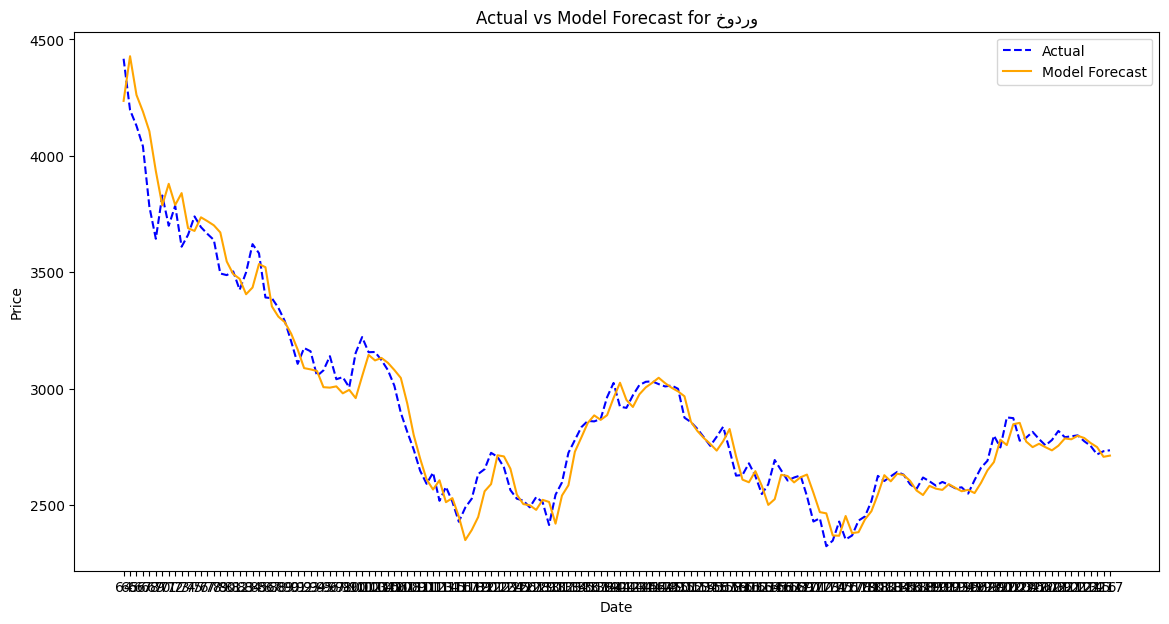

Processing stock: میدکو


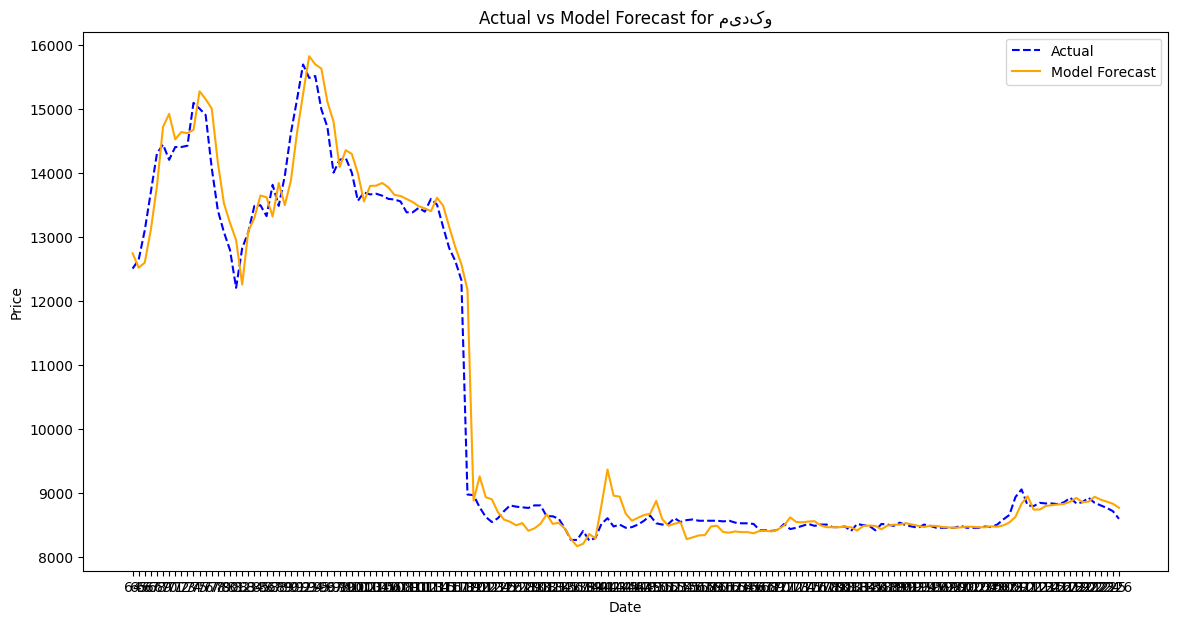

Processing stock: ومعادن


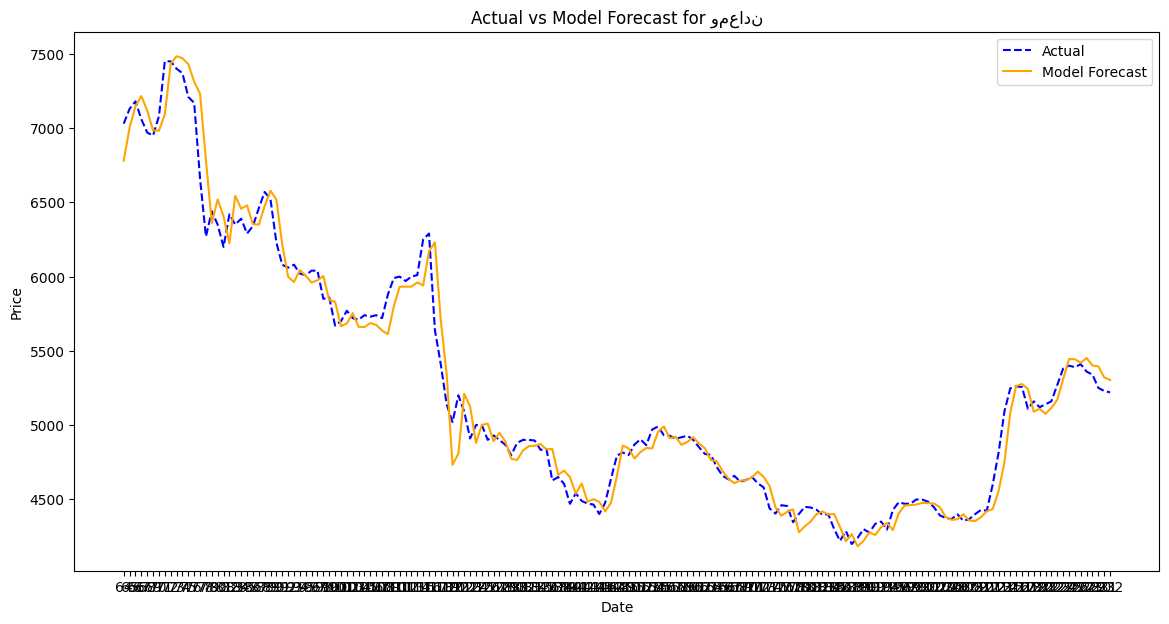

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import timesfm

# List of best stock symbols
best_stocks_user_provided = [
    'فولاد',  # فولاد مبارکه اصفهان
    'فملی',  # ملی صنایع مس ایران
    'رمپنا',  # گروه مپنا
    'فارس',  # پتروشیمی خلیج فارس
    'وبملت',  # بانک ملت
    'شپنا',  # پالایش نفت اصفهان
    'خساپا',  # سایپا
    'خودرو',  # ایران خودرو
    'میدکو',  # هلدینگ صنایع معدنی خاورمیانه
    'ومعادن'  # توسعه معادن و فلزات
]

# Directory where your CSV files are stored
csv_directory = '/content/'  # Update this path

# Function to process each stock
def process_stock_from_csv(stock_symbol):
    file_path = os.path.join(csv_directory, f"{stock_symbol}.csv")

    # Read the CSV file for the stock
    df = pd.read_csv(file_path)

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Filter data between '2023-01-01' and '2023-12-31'
    start_date = '2023-01-01'
    end_date = '2023-12-31'
    data_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Resample data and clean it
    df_clean = data_filtered[['date', 'close']].reset_index(drop=True)

    # TimesFM model input preparation
    def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
        examples = defaultdict(list)
        num_examples = 0
        for start in range(0, len(df_clean) - (context_len + horizon_len), horizon_len):
            num_examples += 1
            context_end = start + context_len
            examples["inputs"].append(df_clean["close"][start:context_end].tolist())
            examples["outputs"].append(df_clean["close"][context_end:context_end + horizon_len].tolist())
            examples["dates"].append(df_clean.index[start:context_end + horizon_len].tolist())  # Add dates to examples

        def data_fn():
            for i in range(1 + (num_examples - 1) // batch_size):
                yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

        return data_fn


    # Get input data for the model
    input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
    metrics = defaultdict(list)
    results = []

    # Process data and forecast
    for i, example in enumerate(input_data()):
        raw_forecast, _ = model.forecast(
            inputs=example["inputs"], freq=[0] * len(example["inputs"])
        )

        for j in range(len(example["inputs"])):
            result = {
                'stock_symbol': stock_symbol,
                'input_index': j,
                'train_start_date': str(example["dates"][j][0]),
                'train_end_date': str(example["dates"][j][-2]),
                'predict_date': str(example["dates"][j][-1]),
                'raw_forecast': raw_forecast[j][0],
                'y_actual': example["outputs"][j][0],
                'batch_size': batch_size,
                'context_len': context_len,
                'input_patch_len': input_patch_len
            }
            results.append(result)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot actual vs forecasted data
    plt.figure(figsize=(14, 7))
    plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
    plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Actual vs Model Forecast for {stock_symbol}')
    plt.legend()
    plt.show()

    return results_df
all_results_df = pd.DataFrame()
# Process each stock in the list
for stock_symbol in best_stocks_user_provided:
    print(f"Processing stock: {stock_symbol}")
    stock_results_df = process_stock_from_csv(stock_symbol)
    all_results_df = pd.concat([all_results_df, stock_results_df], ignore_index=True)



In [33]:
all_results_df

,stock_symbol,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,فولاد,0,0,63,64,6300.250000,6300.0,1,64,32
1,فولاد,0,1,64,65,6282.823242,6320.0,1,64,32
2,فولاد,0,2,65,66,6277.824219,6340.0,1,64,32
3,فولاد,0,3,66,67,6274.094238,6490.0,1,64,32
4,فولاد,0,4,67,68,6340.126953,6840.0,1,64,32
...,...,...,...,...,...,...,...,...,...,...
1626,ومعادن,0,164,227,228,5451.989258,5360.0,1,64,32
1627,ومعادن,0,165,228,229,5400.972656,5340.0,1,64,32
1628,ومعادن,0,166,229,230,5395.319336,5250.0,1,64,32
1629,ومعادن,0,167,230,231,5321.110840,5230.0,1,64,32


In [56]:
 initial_investment = 10000000

In [100]:
def calculate_mse(y_actual, y_forecast):
    return mean_squared_error(y_actual, y_forecast)

# Generalized accuracy function
def calculate_accuracy(y_actual, y_forecast):
    correct_predictions = 0
    total_predictions = 0

    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_forecast.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if actual_movement == 0:
            if predicted_movement != 0:
                total_predictions += 1

        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    b=predicted_movement
    return correct_predictions / total_predictions if total_predictions > 0 else 0

# Generalized profit calculation function
def calculate_profit(y_actual, y_forecast):
    capital = initial_investment
    position = 0

    for i in range(1, len(y_actual)):
        today_price = y_actual.iloc[i]
        yesterday_price = y_actual.iloc[i - 1]
        predicted_today_price = y_forecast.iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_investment

# Generalized actual direction accuracy function
def calculate_actual_direction_accuracy(y_actual, y_forecast):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_actual.iloc[i - 1], y_forecast.iloc[i]))


    return accuracy_score(real_directions, predicted_directions)

# Generalized direction accuracy function
def calculate_direction_accuracy(y_actual, y_forecast):
    correct_predictions = 0
    total_predictions = 0

    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_forecast.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        predicted_yesterday = y_forecast.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - predicted_yesterday
        if actual_movement == 0:
            if predicted_movement != 0:
                total_predictions += 1

        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

# Generalized direction profit calculation function
def calculate_direction_profit(y_actual, y_forecast):
    capital = initial_investment
    position = 0

    for i in range(2, len(y_forecast)):
        yesterday_price = y_actual.iloc[i - 1]
        yesterday_predicted_today_price = y_forecast.iloc[i - 1]
        predicted_today_price = y_forecast.iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_investment

# Generalized naive forecast MSE calculation function
def calculate_naive_mse(y_actual):
    naive_forecast = y_actual.shift(1).dropna()  # Naive forecast is just the previous day's actual value
    return mean_squared_error(y_actual.iloc[1:], naive_forecast)

# Generalized function to calculate results for any context length
def calculate_results_for_context_len(context_len, y_actual, y_forecast):
    mse_value = calculate_mse(y_actual, y_forecast)
    accuracy_value = calculate_accuracy(y_actual, y_forecast)
    profit = calculate_profit(y_actual, y_forecast)
    direction_accuracy = calculate_direction_accuracy(y_actual, y_forecast)
    actual_direction_accuracy = calculate_actual_direction_accuracy(y_actual, y_forecast)
    direction_profit = calculate_direction_profit(y_actual, y_forecast)

    # Calculate naive MSE
    naive_mse = calculate_naive_mse(y_actual)

    # Buy and hold profit calculation

    initial_price = y_actual.iloc[0]
    final_price = y_actual.iloc[-1]

    # Calculate the number of shares bought initially
    shares_bought = initial_investment / initial_price

    # Calculate the final value of the investment
    final_investment_value = shares_bought * final_price

    # Calculate the total profit
    buy_and_hold_profit = final_investment_value - initial_investment

    # Create a dictionary of the results
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit,
        'buy_and_hold_profit': buy_and_hold_profit,
        'naive_mse': naive_mse  # Add naive MSE here
    }

    return pd.DataFrame([result])

In [101]:
for stock_symbol in best_stocks_user_provided:
    print(f"Processing stock: {stock_symbol}")
    results_df=all_results_df[all_results_df['stock_symbol'] == stock_symbol]
    final_result_df = calculate_results_for_context_len(context_len, results_df['y_actual'], results_df['raw_forecast'])
    print(final_result_df)
    print("\n \n \n ")

Processing stock: فولاد
   context_len           mse  accuracy  direction_accuracy  \
0           64  17792.611193      0.44            0.445714   

   actual_direction_accuracy  direction_profit         profit  \
0                    0.50303      2.877182e+06  219052.461796   

   buy_and_hold_profit     naive_mse  
0        -31746.031746  15046.060606  

 
 
 
Processing stock: فملی
   context_len           mse  accuracy  direction_accuracy  \
0           64  19865.351333   0.40678            0.440678   

   actual_direction_accuracy  direction_profit        profit  \
0                   0.506098     382173.301225  1.072569e+06   

   buy_and_hold_profit     naive_mse  
0       -719602.977667  17491.463415  

 
 
 
Processing stock: رمپنا
   context_len           mse  accuracy  direction_accuracy  \
0           64  203249.89126  0.508876            0.502959   

   actual_direction_accuracy  direction_profit        profit  \
0                   0.530488      1.581048e+06 -2.005878e+06